Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📥 Loading and processing images with enhanced preprocessing...


📂 Uninfected: 100%|██████████| 13780/13780 [05:47<00:00, 39.67it/s]



🔧 Creating feature matrix...


Flattening images: 100%|██████████| 27558/27558 [00:02<00:00, 12291.04it/s]



✂️ Splitting data...

📊 Standardizing features...

🔍 Applying PCA...
✅ Explained variance: 75.82%
✅ Final shape: X_train=(22046, 902), X_test=(5512, 902)

🔵 MODEL: LOGISTIC REGRESSION

⏳ Training Logistic Regression...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 971 epochs took 499 seconds

🎯 Logistic Regression Accuracy: 89.28%
🎯 Logistic Regression ROC AUC: 0.9527

📋 Classification Report (Logistic Regression):
              precision    recall  f1-score   support

  Uninfected       0.87      0.93      0.90      2756
 Parasitized       0.92      0.86      0.89      2756

    accuracy                           0.89      5512
   macro avg       0.89      0.89      0.89      5512
weighted avg       0.89      0.89      0.89      5512



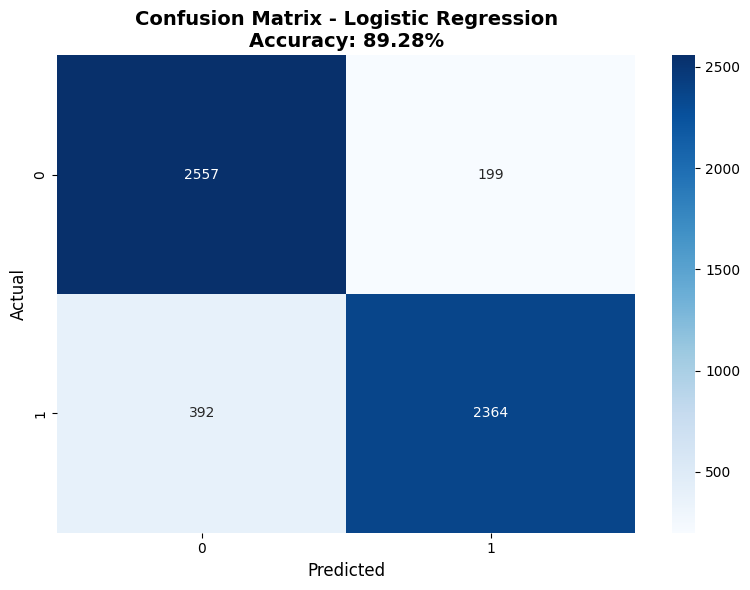


💾 Saving preprocessors and Logistic Regression model...

✅ All files saved successfully!
📁 Location: /content/drive/MyDrive/ML project/preprocessed


In [ ]:
# ==============================
# Mount Google Drive
# ==============================
from google.colab import drive
drive.mount('/content/drive')

# ==============================
# Imports
# ==============================
import cv2
import os
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import gc

# ==============================
# Paths & Config
# ==============================
base_path = "/content/drive/MyDrive/ML project"
parasitized_path = os.path.join(base_path, "Parasitized")
uninfected_path = os.path.join(base_path, "Uninfected")

CONFIG = {
    'target_size': (80, 80),
    'use_clahe': True,
    'gamma': 1.4,
    'test_size': 0.2,
    'random_state': 42,
    'n_components_pca': 800
}

valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

# ==============================
# Enhanced Preprocessing Functions
# ==============================
def adjust_gamma(image, gamma=1.4):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(image, table)

def enhance_image(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge([l_clahe, a, b])
    img_enhanced = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)
    img_enhanced = adjust_gamma(img_enhanced, CONFIG['gamma'])
    kernel = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
    img_enhanced = cv2.filter2D(img_enhanced, -1, kernel)
    img_enhanced = np.clip(img_enhanced, 0, 255).astype('uint8')
    return img_enhanced

def extract_color_features(img):
    features = []
    for i in range(3):
        features.append(np.mean(img[:,:,i]))
        features.append(np.std(img[:,:,i]))
    for i in range(3):
        hist = cv2.calcHist([img], [i], None, [32], [0, 256])
        features.extend(hist.flatten())
    return np.array(features)

def load_images_enhanced(folder_path, label):
    images, labels, color_features = [], [], []
    for root, dirs, files in os.walk(folder_path):
        for filename in tqdm(files, desc=f"📂 {os.path.basename(folder_path)}"):
            if not filename.lower().endswith(valid_extensions):
                continue
            img_path = os.path.join(root, filename)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, CONFIG['target_size'], interpolation=cv2.INTER_AREA)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = enhance_image(img)
            color_feat = extract_color_features(img)
            color_features.append(color_feat)
            img = img.astype('float32') / 255.0
            images.append(img)
            labels.append(label)
    return images, labels, color_features

# ==============================
# Load Data
# ==============================
print("📥 Loading and processing images with enhanced preprocessing...")
parasitized_images, parasitized_labels, parasitized_colors = load_images_enhanced(parasitized_path, 1)
uninfected_images, uninfected_labels, uninfected_colors = load_images_enhanced(uninfected_path, 0)

images = parasitized_images + uninfected_images
labels = parasitized_labels + uninfected_labels
color_features = parasitized_colors + uninfected_colors

del parasitized_images, uninfected_images, parasitized_labels, uninfected_labels
del parasitized_colors, uninfected_colors
gc.collect()

# ==============================
# Create Feature Matrix
# ==============================
print("\n🔧 Creating feature matrix...")
n_samples = len(images)
n_features = images[0].flatten().shape[0]

X_image = np.empty((n_samples, n_features), dtype='float32')
y = np.array(labels)

for i in tqdm(range(n_samples), desc="Flattening images"):
    X_image[i] = images[i].flatten()

del images, labels
gc.collect()

X_color = np.array(color_features, dtype='float32')
del color_features
gc.collect()

# ==============================
# Train-Test Split
# ==============================
print("\n✂️ Splitting data...")
X_image_train, X_image_test, X_color_train, X_color_test, y_train, y_test = train_test_split(
    X_image, X_color, y,
    test_size=CONFIG['test_size'],
    stratify=y,
    random_state=CONFIG['random_state']
)

del X_image, X_color, y
gc.collect()

# ==============================
# Standardization
# ==============================
print("\n📊 Standardizing features...")
scaler_image = StandardScaler()
X_image_train = scaler_image.fit_transform(X_image_train)
X_image_test = scaler_image.transform(X_image_test)

scaler_color = StandardScaler()
X_color_train = scaler_color.fit_transform(X_color_train)
X_color_test = scaler_color.transform(X_color_test)

# ==============================
# PCA
# ==============================
print("\n🔍 Applying PCA...")
pca = PCA(n_components=CONFIG['n_components_pca'], random_state=CONFIG['random_state'])
X_image_train_pca = pca.fit_transform(X_image_train)
X_image_test_pca = pca.transform(X_image_test)

print(f"✅ Explained variance: {pca.explained_variance_ratio_.sum()*100:.2f}%")

X_train = np.hstack([X_image_train_pca, X_color_train])
X_test = np.hstack([X_image_test_pca, X_color_test])

del X_image_train, X_image_test, X_image_train_pca, X_image_test_pca
del X_color_train, X_color_test
gc.collect()

print(f"✅ Final shape: X_train={X_train.shape}, X_test={X_test.shape}")

# ==============================
# Logistic Regression Only
# ==============================
print("\n" + "="*60)
print("🔵 MODEL: LOGISTIC REGRESSION")
print("="*60)

log_reg = LogisticRegression(
    C=1.0,
    max_iter=2000,
    solver='saga',
    penalty='l2',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("\n⏳ Training Logistic Regression...")
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

accuracy_lr = accuracy_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)

print(f"\n🎯 Logistic Regression Accuracy: {accuracy_lr*100:.2f}%")
print(f"🎯 Logistic Regression ROC AUC: {roc_auc_lr:.4f}")

print("\n📋 Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr, target_names=['Uninfected', 'Parasitized']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title(f"Confusion Matrix - Logistic Regression\nAccuracy: {accuracy_lr*100:.2f}%",
          fontsize=14, fontweight='bold')
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.tight_layout()
plt.show()

# ==============================
# Save Preprocessors & Model
# ==============================
print("\n💾 Saving preprocessors and Logistic Regression model...")
save_path = "/content/drive/MyDrive/ML project/preprocessed"
os.makedirs(save_path, exist_ok=True)

with open(os.path.join(save_path, "scaler_image.pkl"), "wb") as f:
    pickle.dump(scaler_image, f)
with open(os.path.join(save_path, "scaler_color.pkl"), "wb") as f:
    pickle.dump(scaler_color, f)
with open(os.path.join(save_path, "pca.pkl"), "wb") as f:
    pickle.dump(pca, f)
with open(os.path.join(save_path, "logistic_regression_model.pkl"), "wb") as f:
    pickle.dump(log_reg, f)
with open(os.path.join(save_path, "config.pkl"), "wb") as f:
    pickle.dump(CONFIG, f)

print("\n✅ All files saved successfully!")
print(f"📁 Location: {save_path}")


Mounted at /content/drive
📥 Loading and processing images...


📂 Uninfected: 100%|██████████| 13780/13780 [06:29<00:00, 35.38it/s] 



🔧 Creating feature matrix...


Flattening images: 100%|██████████| 27558/27558 [00:01<00:00, 25543.21it/s]



✂️ Splitting data...

📊 Standardizing features...

🔍 Applying PCA...
✅ Final shape: X_train=(22046, 902), X_test=(5512, 902)

🟠 MODEL: K-MEANS CLUSTERING
⏳ Training K-Means...
Initialization complete
Iteration 0, inertia 432417984.0.
Iteration 1, inertia 301382912.0.
Iteration 2, inertia 297988864.0.
Iteration 3, inertia 297715488.0.
Iteration 4, inertia 297684672.0.
Iteration 5, inertia 297681056.0.
Iteration 6, inertia 297680192.0.
Iteration 7, inertia 297679712.0.
Iteration 8, inertia 297679232.0.
Iteration 9, inertia 297678624.0.
Iteration 10, inertia 297677760.0.
Iteration 11, inertia 297677792.0.
Iteration 12, inertia 297678016.0.
Iteration 13, inertia 297677888.0.
Iteration 14, inertia 297679168.0.
Converged at iteration 14: center shift 0.0006425558240152895 within tolerance 0.0016252878122031689.
Initialization complete
Iteration 0, inertia 443412512.0.
Iteration 1, inertia 310396320.0.
Iteration 2, inertia 304647040.0.
Iteration 3, inertia 299987328.0.
Iteration 4, inertia 2

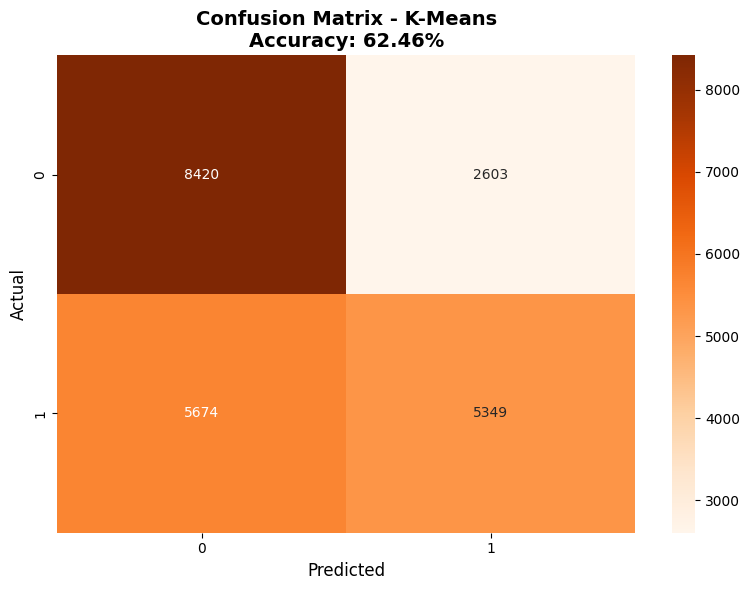


💾 Saving preprocessors and K-Means model...

✅ All files saved successfully!
📁 Location: /content/drive/MyDrive/ML project/preprocessed
🎯 Ensemble K-Means Accuracy: 62.46%


MiniBatchKMeans(batch_size=1000, max_iter=500, n_clusters=2, n_init=50,
                random_state=42)

In [ ]:
# ==============================
# Mount Google Drive
# ==============================
from google.colab import drive
drive.mount('/content/drive')

# ==============================
# Imports
# ==============================
import cv2
import os
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import gc

# ==============================
# Paths & Config
# ==============================
base_path = "/content/drive/MyDrive/ML project"
parasitized_path = os.path.join(base_path, "Parasitized")
uninfected_path = os.path.join(base_path, "Uninfected")

CONFIG = {
    'target_size': (80, 80),
    'use_clahe': True,
    'gamma': 1.4,
    'test_size': 0.2,
    'random_state': 42,
    'n_components_pca': 800
}

valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

# ==============================
# Preprocessing Functions
# ==============================
def adjust_gamma(image, gamma=1.4):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(image, table)

def enhance_image(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge([l_clahe, a, b])
    img_enhanced = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)
    img_enhanced = adjust_gamma(img_enhanced, CONFIG['gamma'])
    kernel = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
    img_enhanced = cv2.filter2D(img_enhanced, -1, kernel)
    img_enhanced = np.clip(img_enhanced, 0, 255).astype('uint8')
    return img_enhanced

def extract_color_features(img):
    features = []
    for i in range(3):
        features.append(np.mean(img[:,:,i]))
        features.append(np.std(img[:,:,i]))
    for i in range(3):
        hist = cv2.calcHist([img], [i], None, [32], [0, 256])
        features.extend(hist.flatten())
    return np.array(features)

def load_images_enhanced(folder_path, label):
    images, labels, color_features = [], [], []
    for root, dirs, files in os.walk(folder_path):
        for filename in tqdm(files, desc=f"📂 {os.path.basename(folder_path)}"):
            if not filename.lower().endswith(valid_extensions):
                continue
            img_path = os.path.join(root, filename)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, CONFIG['target_size'], interpolation=cv2.INTER_AREA)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = enhance_image(img)
            color_feat = extract_color_features(img)
            color_features.append(color_feat)
            img = img.astype('float32') / 255.0
            images.append(img)
            labels.append(label)
    return images, labels, color_features

# ==============================
# Load Data
# ==============================
print("📥 Loading and processing images...")
parasitized_images, parasitized_labels, parasitized_colors = load_images_enhanced(parasitized_path, 1)
uninfected_images, uninfected_labels, uninfected_colors = load_images_enhanced(uninfected_path, 0)

images = parasitized_images + uninfected_images
labels = parasitized_labels + uninfected_labels
color_features = parasitized_colors + uninfected_colors

del parasitized_images, uninfected_images, parasitized_labels, uninfected_labels
del parasitized_colors, uninfected_colors
gc.collect()

# ==============================
# Create Feature Matrix
# ==============================
print("\n🔧 Creating feature matrix...")
n_samples = len(images)
n_features = images[0].flatten().shape[0]

X_image = np.empty((n_samples, n_features), dtype='float32')
y = np.array(labels)

for i in tqdm(range(n_samples), desc="Flattening images"):
    X_image[i] = images[i].flatten()

del images, labels
gc.collect()

X_color = np.array(color_features, dtype='float32')
del color_features
gc.collect()

# ==============================
# Train-Test Split
# ==============================
print("\n✂ Splitting data...")
X_image_train, X_image_test, X_color_train, X_color_test, y_train, y_test = train_test_split(
    X_image, X_color, y,
    test_size=CONFIG['test_size'],
    stratify=y,
    random_state=CONFIG['random_state']
)

del X_image, X_color, y
gc.collect()

# ==============================
# Standardization
# ==============================
print("\n📊 Standardizing features...")
scaler_image = StandardScaler()
X_image_train = scaler_image.fit_transform(X_image_train)
X_image_test = scaler_image.transform(X_image_test)

scaler_color = StandardScaler()
X_color_train = scaler_color.fit_transform(X_color_train)
X_color_test = scaler_color.transform(X_color_test)

# ==============================
# PCA
# ==============================
print("\n🔍 Applying PCA...")
pca = PCA(n_components=CONFIG['n_components_pca'], random_state=CONFIG['random_state'])
X_image_train_pca = pca.fit_transform(X_image_train)
X_image_test_pca = pca.transform(X_image_test)

X_train = np.hstack([X_image_train_pca, X_color_train])
X_test = np.hstack([X_image_test_pca, X_color_test])

del X_image_train, X_image_test, X_image_train_pca, X_image_test_pca
del X_color_train, X_color_test
gc.collect()

print(f"✅ Final shape: X_train={X_train.shape}, X_test={X_test.shape}")

# ==============================
# K-Means Model
# ==============================
print("\n🟠 MODEL: K-MEANS CLUSTERING")

kmeans = KMeans(
    n_clusters=2,
    random_state=42,
    n_init=20,
    verbose=1
)

print("⏳ Training K-Means...")
kmeans.fit(X_train)

# ==============================
# Map clusters to labels (Fixed)
# ==============================
def map_clusters_to_labels(y_true, y_clusters):
    labels_map = {}
    for cluster in np.unique(y_clusters):
        mask = (y_clusters == cluster)
        most_common = mode(y_true[mask], keepdims=True).mode[0]
        labels_map[cluster] = most_common
    y_pred_mapped = np.vectorize(labels_map.get)(y_clusters)
    return y_pred_mapped

y_pred_kmeans = map_clusters_to_labels(y_train, kmeans.labels_)

# ==============================
# Evaluate
# ==============================
accuracy_kmeans = accuracy_score(y_train, y_pred_kmeans)
print(f"\n🎯 K-Means Accuracy (train): {accuracy_kmeans*100:.2f}%")
print("\n📋 Classification Report:")
print(classification_report(y_train, y_pred_kmeans, target_names=['Uninfected', 'Parasitized']))

plt.figure(figsize=(8,6))
cm = confusion_matrix(y_train, y_pred_kmeans)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=True)
plt.title(f"Confusion Matrix - K-Means\nAccuracy: {accuracy_kmeans*100:.2f}%", fontsize=14, fontweight='bold')
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.tight_layout()
plt.show()

# ==============================
# Save Preprocessors & K-Means Model
# ==============================
print("\n💾 Saving preprocessors and K-Means model...")
save_path = "/content/drive/MyDrive/ML project/preprocessed"
os.makedirs(save_path, exist_ok=True)

with open(os.path.join(save_path, "scaler_image.pkl"), "wb") as f:
    pickle.dump(scaler_image, f)
with open(os.path.join(save_path, "scaler_color.pkl"), "wb") as f:
    pickle.dump(scaler_color, f)
with open(os.path.join(save_path, "pca.pkl"), "wb") as f:
    pickle.dump(pca, f)
with open(os.path.join(save_path, "kmeans_model.pkl"), "wb") as f:
    pickle.dump(kmeans, f)
with open(os.path.join(save_path, "config.pkl"), "wb") as f:
    pickle.dump(CONFIG, f)

print("\n✅ All files saved successfully!")
print(f"📁 Location: {save_path}")